In [2]:
!pip install prophet

In [ ]:
!python -m pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.1 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached httpstan-4.13.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pysimdjson-6.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached crashtest-0.3.1-py3-none-any.whl.metadata (748 bytes)
  Using cached pastel-0.2.1-py2.py3-none-any.whl.metadata (1.9 kB)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet

from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly

from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')


In [5]:
df = pd.read_csv('FactClient.csv')

print(df.head())
print("\n",df.info())
print("-----------------------------")
print("\nDate_fk range:", df['Date_fk'].min(), "to", df['Date_fk'].max())
print("-----------------------------")

print("TotalFlights statistics:")
print("\n",df['TotalFlights'].describe())
print("-----------------------------")

print(df.isnull().sum())

   Member_fk   Date_fk  JoinDate_fk  CancellationDate_fk  Tier_fk  \
0       2321  20180801     20160801                  NaN        1   
1       4503  20170901     20130301                  NaN        2   
2       4381  20170401     20160701                  NaN        2   
3        168  20171201     20150801                  NaN        3   
4      14278  20180301     20140101                  NaN        3   

   Residency_fk  TotalFlights  Distance  PointsAccumulated  PointsRedeemed  \
0            23             0         0                  0               0   
1            21             3      5040               5040               0   
2            12             4      5272               5272               0   
3            27             3      7170               7170               0   
4            28             0         0                  0               0   

   DollarCostPointsRedeemed     CLV  
0                       0.0  7919.0  
1                       0.0  2887.0  
2 

In [6]:

df['ds'] = pd.to_datetime(df['Date_fk'].astype(str), format='%Y%m%d')
df_monthly = (
    df
    .groupby(pd.Grouper(key='ds', freq='M'))
    .agg({'TotalFlights': 'sum'})
    .reset_index()
)

df_monthly.rename(columns={'TotalFlights': 'y'}, inplace=True)


print(f"Aggregated data shape: {df_monthly.shape}")

df_monthly.head()

Aggregated data shape: (24, 2)


,ds,y
0,2017-01-31,964
1,2017-02-28,726
2,2017-03-31,896
3,2017-04-30,841
4,2017-05-31,984


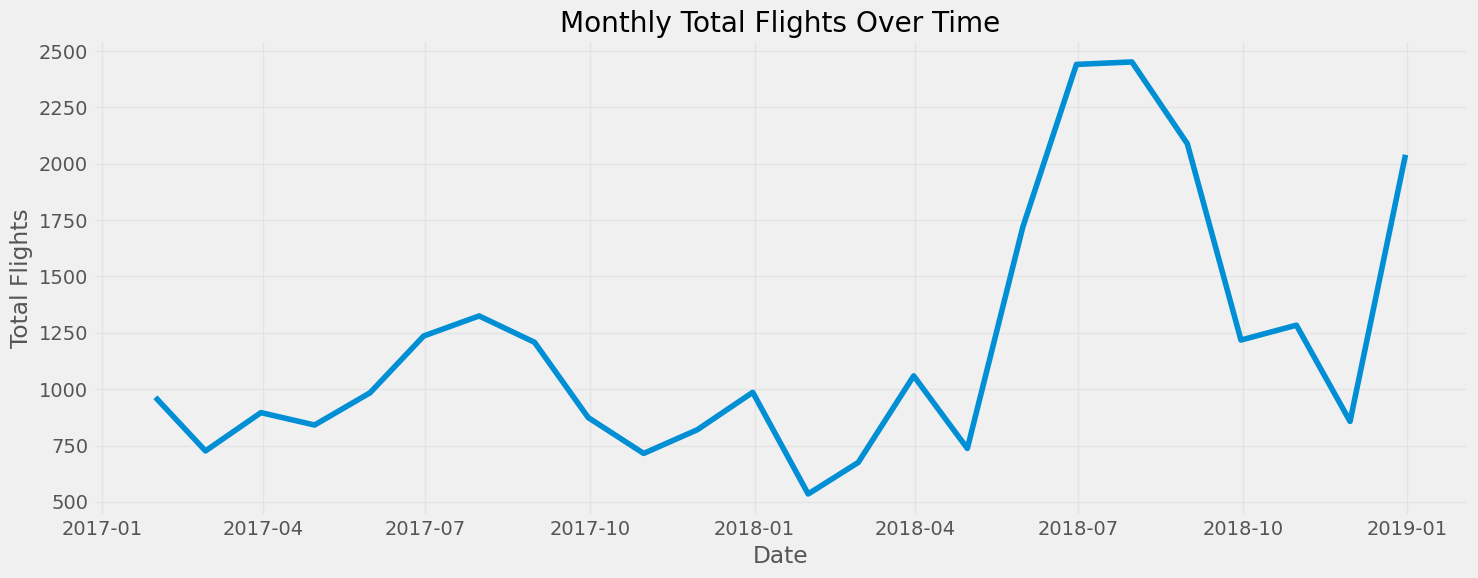

In [7]:
# Plot the time series
df['Date'] = pd.to_datetime(df['Date_fk'].astype(str), format='%Y%m%d')

plt.figure(figsize=(15, 6))
plt.plot(df_monthly['ds'], df_monthly['y'])
plt.title('Monthly Total Flights Over Time')
plt.xlabel('Date')
plt.ylabel('Total Flights')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# Hold out last 6 months
test_size = 4

train = df_monthly.iloc[:-test_size]
test  = df_monthly.iloc[-test_size:]


In [9]:
#Initializing Prophet model
model = Prophet(
    #repeats yearly, weekly irrelevant same for daily
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False
)

model.fit(train)

INFO:prophet:n_changepoints greater than number of observations. Using 15.


In [10]:
future = model.make_future_dataframe(
    periods=len(test),
    freq='M'
)

forecast = model.predict(future)

In [11]:
forecast_test = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(len(test))

comparison = test.merge(
    forecast_test,
    on='ds',
    how='left'
)


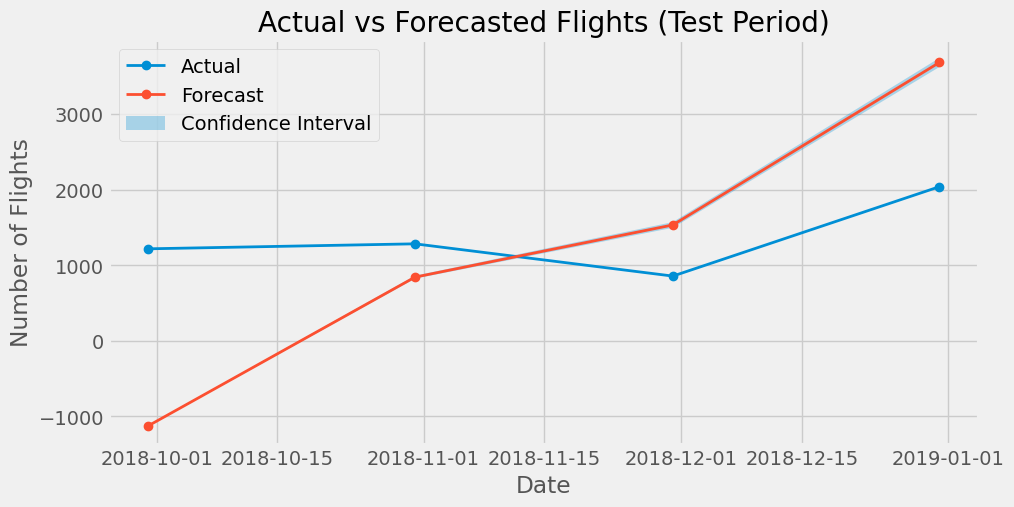

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(comparison['ds'], comparison['y'],
         marker='o', linewidth=2, label='Actual')

plt.plot(comparison['ds'], comparison['yhat'],
         marker='o', linewidth=2, label='Forecast')

plt.fill_between(
    comparison['ds'],
    comparison['yhat_lower'],
    comparison['yhat_upper'],
    alpha=0.3,
    label='Confidence Interval'
)

plt.title('Actual vs Forecasted Flights (Test Period)')
plt.xlabel('Date')
plt.ylabel('Number of Flights')
plt.legend()
plt.grid(True)
plt.show()


In [13]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae  = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
mape = np.mean(np.abs((comparison['y'] - comparison['yhat']) / comparison['y'])) * 100

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")


MAE  : 1276.24
RMSE : 1486.85
MAPE : 96.57%


In [14]:
import joblib

joblib.dump(model, "FlightsPrediction.pkl")

print("✅ Prophet model saved")



✅ Prophet model saved
